In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# numero cuantico m, m = -J,-J+1,-J+2,...,J-1,J
m_numbers = lambda J: np.arange(-J, J+1)


def build_system(SIZE, m):

    """Microestado inicial aleatorio. Crea una red triangular"""

    num_rows, num_cols = SIZE, SIZE

    # Create an empty triangular lattice
    lattice = np.zeros((num_rows, num_cols))

    # Accessing each site in the lattice
    for i in range(num_rows):
        for j in range(num_cols):
            if int(i % 2) == 0:  # For even rows
                if int(j % 2) == 0:  # For even columns
                    # Example: Assign a value to the site
                    lattice[i, j] = np.random.choice(m)
            else:  # For odd rows
                if int(j % 2) != 0:  # For odd columns
                    # Example: Assign a value to the site
                    lattice[i, j] = np.random.choice(m)

    return lattice


def metropolis(config,J,B,T):

    """ Algoritmo de metropolis 
    config = Configuracion del sistema
    m = número cuantico m
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura
    """

    E = 0 #Energía
    L = len(config) # Tamaño 
    for i in range(L):
        for j in range(L):

            conf_i = config[i, j] 

            # sitios vecinos
            conf_j = config[(i+1)%L, (j+1)%L] +  config[(i+1)%L, (j-1)%L] + config[(i-1)%L, (j-1)%L] + config[(i-1)%L, (j+1)%L]

            # Energia inicial del sitio
            Ei = -J*np.dot(conf_i,conf_j) - conf_i*B 

            # Fluctuar el espín del sitio seleccionado
            conf_trial = config[i, j] * -1

            # Calculo de Energia luego de perturbar el vector a evaluar
            Ef = -J*np.dot(conf_trial,conf_j) - conf_trial*B 
            
            # Diferencia entre energia luego de perturbar el sitio y energia inicial
            Delta_E = Ef - Ei 

            # Criterio de montecarlo, si minimiza la energia permitir la perturbacion
            if Delta_E <= 0 or np.random.rand() <= np.exp(-Delta_E/T): 
                conf_i = conf_trial
                E += Delta_E

            # almacena la configuracion que cumple la condición
            config[i, j] = conf_i 

    return config, E

In [39]:
build_system(100, m_numbers(1/2))

array([[-0.5,  0. ,  0.5, ...,  0. ,  0.5,  0. ],
       [ 0. , -0.5,  0. , ..., -0.5,  0. ,  0.5],
       [ 0.5,  0. ,  0.5, ...,  0. ,  0.5,  0. ],
       ...,
       [ 0. ,  0.5,  0. , ...,  0.5,  0. , -0.5],
       [ 0.5,  0. , -0.5, ...,  0. , -0.5,  0. ],
       [ 0. ,  0.5,  0. , ...,  0.5,  0. , -0.5]])

In [40]:
def montecarlo_step(config,J,B,T):
    '''
    Funcion que permite implementar la funcion de montecarlo, calculo de energia total, magnetizacion promedio
    config = Configuracion a evolucionar.
    m = Lista de numero cuantico m
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura 
    '''
    # número máximo de pasos de montecarlo
    MCSmax = 100

    # Energía
    Energy = 0 
    Energy2 = 0

    # Magnetización
    Magnetiz = 0

    # criterio de estabilidad en la medida
    to = int(MCSmax/2)

    for mcs in range(MCSmax):
        # evolución del sistema
        config, energy = metropolis(config,J,B,T) 
        
        if mcs > to: 
            Magnetiz += np.sum(config) # calculo de magnetizacion
            Energy += energy
            Energy2 += energy**2
    
    Magnetiz = Magnetiz/(MCSmax-to) # Magnetizacion promedio
    Energy = Energy/(MCSmax-to)     # Energía promedio
    Energy2 = Energy2/(MCSmax-to)

    return Magnetiz, Energy, Energy2



def main(s,J,B,T):

    """
    Función pincipal que ejecuta el algoritmo de Metropolis
    para distintos valores de temperatura
    Retorna un array de la magnetización y energía promedio
    s = Spin
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura
    """

    SIZE=100

    m = m_numbers(s)

    # Configuracion inicial    
    config_i = build_system(SIZE, m) 
    
    # Magnetizacion
    M = [] 

    # Energía
    E = [] 
    E2 = [] 

    # recorre los valores de temperatura 
    for i,t in enumerate(T): 

        # barra de progreso
        utils.progressBar(i+1, len(T))

        # evoluciona el sistema 
        Magnetiz, Energy, Energy2 = montecarlo_step(config_i, J, B, t) 
        
        M.append(Magnetiz)
        E.append(Energy)
        E2.append(Energy2)
        
    
    return np.array(M), np.array(E), np.array(E2)

In [41]:
def frustated():

    """
    Ejecuta el algoritmo principal con distintos 
    valores de temperatura. Guarda archivos con temperatura 
    vs. Magnetización
    """

    B=0

    # Temperatura
    T  = np.linspace(1.5,0.001,200)
    M, E, E2 = main(s=1/2, J=-1, B=B, T=T)

    utils.save_lists_as_columns(f"MvsT_antiferro2.txt", T, M)
    utils.save_lists_as_columns(f"T_E_antiferro.txt", T, np.column_stack((E, E2)))

In [42]:
frustated()

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [45]:
def graph():
    data = np.loadtxt(f"MvsT_antiferro.txt").T
    max = np.max(data[1])
    plt.plot(data[0], data[1]/max, alpha=0.5, c="b") 
    plt.xlabel("T")
    plt.ylabel("<M>/M_max")
    plt.grid()

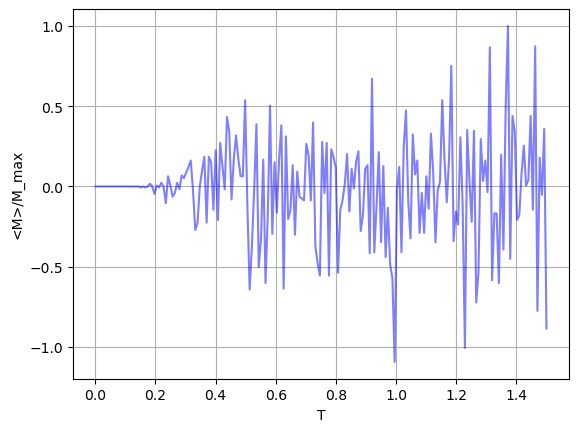

In [46]:
graph()